## Methods & Results:

In [71]:
# imports 

library(tidyverse)
library(repr)
library(themis)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)


### Summary of methods used to perform analysis

For our analysis, we began by preprocessing the `players.csv` dataset, removing unnecessary features such as `gender`, `name`, `hashedEmail`, and `played_hours`. The dataset was then split into a training set containing 75% of the data and a test set containing the remaining 25%. To ensure reproducibility, we set a random seed before specifying our model. We chose K-Nearest Neighbours (KNN) as our model since the task was a classification problem. During the data split, we stratified by the target variable `subscribe`. All predictor columns in the KNN recipe were standardized so that each variable contributed equally to the distance calculations. We then performed 5-fold cross-validation on the training set to tune the number of neighbours(K) in the model. Finally, we used the best-performing K to fit a final model and made predictions on the test set and measured the recall and accuracy of our results.

In [72]:
# ----------- loading the data in -------------
players = read_csv('data/players.csv')


# ------------- Data cleaning --------------

# only selecting columns that are needed
players = select(players, Age, experience, subscribe)

# Encoding the experience column
players$experience = factor(players$experience, levels = c("Amateur", "Beginner", "Regular", "Pro", "Veteran"), ordered = TRUE)

# Converting target to factor type and dropping rows with missing values
players = players |> 
        mutate(subscribe = factor(subscribe)) |>
        drop_na()

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Data Wrangling**
- Above we have selected the columns that are relevant for our analysis (`Age`, `experience` and `subscribe`). 
- We used ordinal encoding on the experience column of the dataset since it is a categorical variable with an order. We set the order of the categories as **"Amateur", "Beginner", "Regular", "Pro", "Veteran"**
- We also converted `subscribe` (target variable) to a factor, as this is a classification problem.
- There were also missing values in the data, which we decided to drop.  

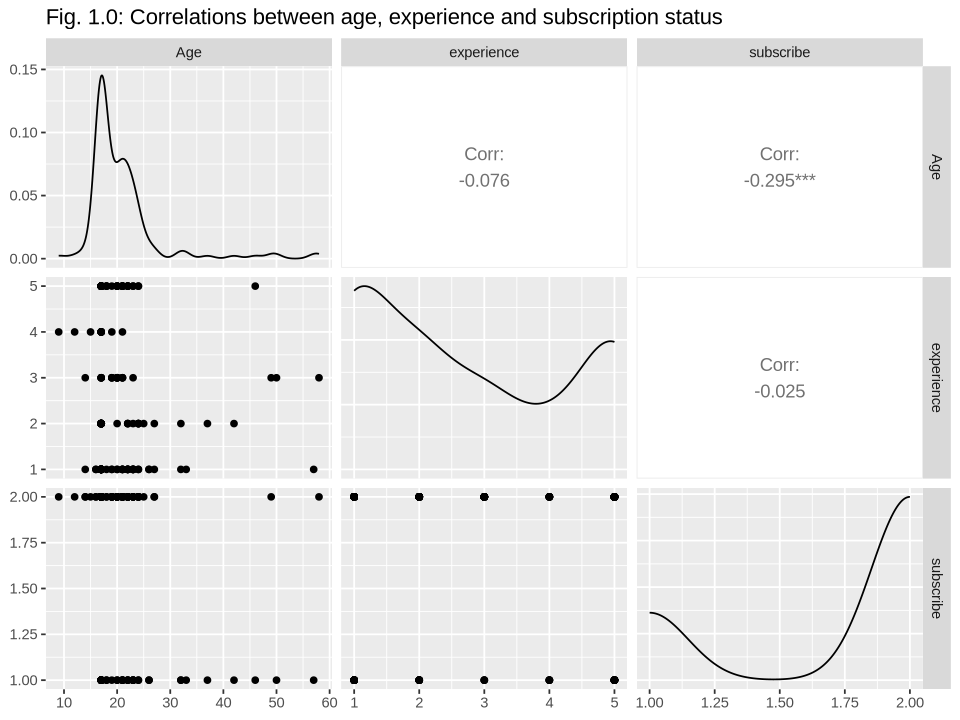

In [73]:
options(repr.plot.width = 8, repr.plot.height = 6)
# Setting the seed for reproducibility.
set.seed(3456) 

# Splitting the data into a 75% training split and a 25% test split 
players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

players_numerical <- players_train |>
  mutate(
    Age = as.numeric(Age),
    experience = as.numeric(experience),
    subscribe = as.numeric(subscribe)
  )


# Visualizing of the training data
data_viz <- ggpairs(players_numerical) +
  ggtitle("Fig. 1.0: Correlations between age, experience and subscription status")

data_viz

From the visualization above, it is evident that : 
- There is more data for people within the age range of 20-30, and there is very little data for people who are 30+.
- There is a lot of data for people whose experience level is Amateur (encoded as 1), and there is little data for people whose experience level is Pro (encoded as 4).
- There are a lot of FALSE `subscribe` values (encoded as 2), but not a lot of true `subscribe` values (encoded as 1)
- There is a low correlation between subscription and both predictor variables (Age and experience). This indicates that `Age` and `experience` alone may be poor predictors of the target; however, in combination, they could identify a signal.
- Overall, the data has a large imbalance across all columns, and we anticipate that this will affect the model's results.
- Since there is a large class imbalance in our target variable (`subscribe`), it is likely that we will get a high accuracy and a poor recall score.

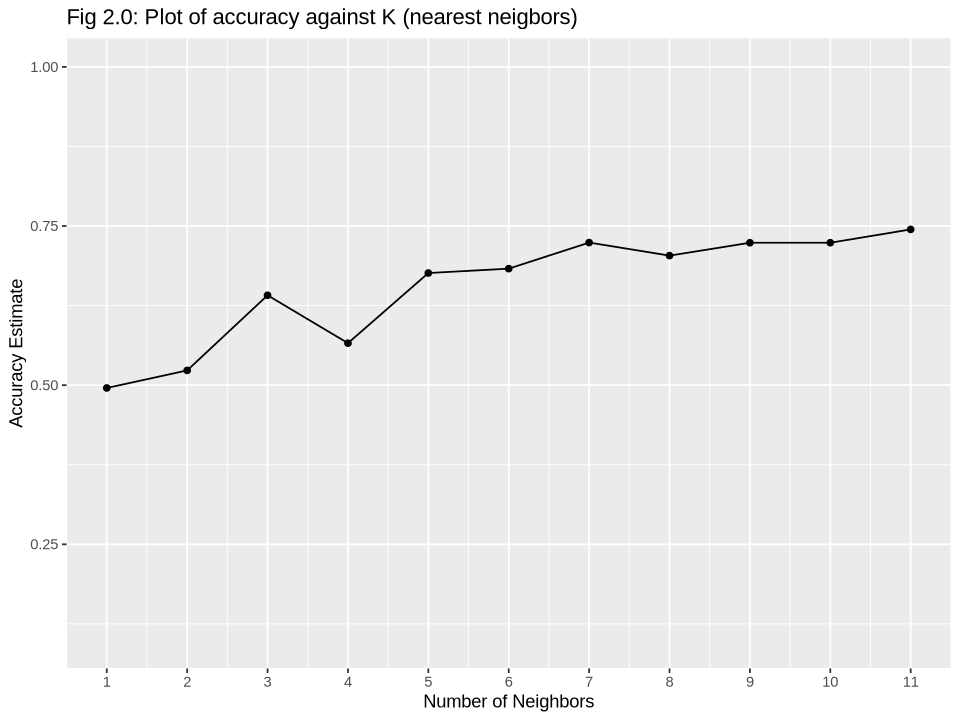

In [74]:
# Making a recipe and scaling + centering data
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_scale(all_numeric_predictors()) |>
    step_center(all_numeric_predictors()) |>
    step_dummy(all_nominal_predictors())  # converting predictors to numerical values


# Cross-validation and model tuning
number_vfold  = vfold_cv(players_train, v = 5, strata = subscribe) 

# Testing values of K from 1 to 12
k_vals <- tibble(neighbors = seq(from = 1, to = 11, by = 1))

knn_tune = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")


# Making the workflow
knn_results <- workflow() |> 
       add_recipe(players_recipe) |> 
       add_model(knn_tune) |>  
       tune_grid(resamples = number_vfold, grid = k_vals) |>
       collect_metrics() |>
       filter(.metric == "accuracy")
     

# Making a plot of accuracy against K score
cross_val_plot = knn_results |>
        ggplot(aes(x=neighbors ,y=mean)) +
        geom_point() +
        geom_line() + 
        labs(x = "Number of Neighbors" , y = "Accuracy Estimate") + 
        ggtitle("Fig 2.0: Plot of accuracy against K (nearest neigbors)") + 
        scale_x_continuous(breaks = seq(0, 14, by = 1)) +
        scale_y_continuous(limits = c(0.1, 1.0))


cross_val_plot

The code above performs a K-Nearest Neighbours (KNN) classification analysis on the `players_train` dataset. First, we created a recipe where all numeric predictors are scaled and centred, and categorical predictors are converted to dummy variables. Next, we applied 5-fold cross-validation, stratifying by the target variable `subscribe`. We specified a grid of K values from 1 to 11 to test different numbers of neighbours for the KNN model and created a workflow to tune our model. We collected the results and filtered to only retain the accuracy metric. Finally, we created a plot to display the mean accuracy against the number of neighbours, to show how model performance varies with different K values. 

From the plot, it is evident that the value of K, which gives the highest accuracy estimate, is 11. The Accuracy estimate is around 0.75, which is not a great score. Some potential reasons for this could be: 
- The predictor variables did not have a high correlation with the target.
- The `Age` variable did not have a wide range of data and was also in continuous form. Discretizing `Age` could further improve model performance because patterns may be more easily uncovered in age categories.
- The dataset is not large.


In [75]:
# Making a new model with our best value of K
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
       set_engine("kknn") |>
       set_mode("classification")

# making a workflow for the best model
players_fit <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(knn_spec) |>
       fit(data = players_train)

#predicting on our test set
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)


# getting the accuracy of the predictions on our test set
players_prediction_accuracy <- players_test_predictions |>
         metrics(truth = subscribe, estimate = .pred_class) |>
         filter(.metric == "accuracy")

players_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


We can see above that our test set had an accuracy of around 0.71. That is close to the score that we got on our training set. The accuracy score on the test set is also not great. 

In [76]:
# Plotting a confusion matrix to see what the recall and precision looks like
players_mat <- players_test_predictions |> 
       conf_mat(truth = subscribe, estimate = .pred_class)

players_mat

          Truth
Prediction FALSE TRUE
     FALSE     1    2
     TRUE     12   34

From the confusion matrix above we can see that: 

We have: 
- 1 true Negative
- 2 false Negatives
- 12 false Positives
- 34 true Positives

This indicates that our model is predicting `TRUE` a lot more than it is predicting false and we have a high recall score.
We can calculate recall using the formula `TP/(TP + FN)` which would be `(34)/(34 + 2) = 0.944`.

That is a very high recall score! Since we are more interested in predicting the `TRUE` class, that can be good. However, the model is very bad at predicting the `FALSE` class. 

We expected this behaviour since there was a significant class imbalance in our target variable. If we wanted to optimize our accuracy and focus on predicting the `FALSE` class correctly, too, we could balance the class weights.

### References

- Greg Martin. (2015, September 3). Factor into numeric in R [Online forum post]. Stack Overflow. https://stackoverflow.com/questions/32370731/factor-into-numeric-in-r
- Mozumdar, A. (2020, February). A guide to encoding categorical features using R. R‑bloggers. https://www.r-bloggers.com/2020/02/a-guide-to-encoding-categorical-features-using-r/